# 🎬 **Gross Box Office Revenue Collection (opening week) Prediction**
This notebook builds a machine learning model to predict a movie’s **domestic first 7-day box office revenue** using only *pre-release information*, while carefully avoiding data leakage.

## **Project Goals**

1. Load and inspect the final master movie dataset
2. Clean and prepare data for modeling
3. Engineer leakage-safe, pre-release features
4. Predict first 7-day domestic box office revenue (bom_first7_sum
5. Build a robust and interpretable forecasting model


## **Target Variable**
***bom_first7_sum***  : cumulative domestic box office revenue during the first 7 days after release

## **Modeling Assumptions**

* Only **information** available **before release** is used
* **Historical performance** of actors, directors, distributors, and franchises is computed using **prior releases only**
* **Post-release signals** (e.g., IMDb ratings, daily box office) are **excluded**
* **Cold-start cases** are handled using **history-availability indicators**

In [320]:
# Installations

!pip install xgboost
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install optuna
!pip install shap

In [321]:
# Import libraries

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


import optuna
import shap


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


sns.set(style="whitegrid")

In [322]:
# Load dataset

df = pd.read_csv("MASTER DATASET.csv")

# Preview data

df.head()


,tmdb_id,imdb_id,title_tmdb,title_imdb,title_norm,release_origin,genres_tmdb,release_date_tmdb,release_date_imdb,budget_tmdb,runtime_tmdb,mpaa_rating_tmdb,popularity_tmdb,log_yt_viewCount,cast_top10_y,lead_actor,lead_actor_demand_weighted,actor_has_prior_history,director_name_clean,director_demand_weighted,director_has_prior_history,distributor,distributor_size_encoded,distributor_avg_first7_gross_prior,distributor_avg_opening_theaters_prior,distributor_has_prior_history,franchise_id,franchise_name,is_franchise,is_sequel,is_sequel_confidence,is_first_in_franchise,movies_before_this,franchise_has_prior_history,franchise_avg_gross_prior,franchise_highest_gross_prior,is_christmas_week,is_newyear_week,is_thanksgiving_week,is_easter_week,is_long_weekend_release,release_season,release_month_sin,release_month_cos,bom_day1,bom_day2,bom_day3,bom_day4,bom_day5,bom_day6,bom_day7,bom_opening_theaters,bom_first7_sum
0,19901,433362.00,Daybreakers,Daybreakers,daybreakers,Original Release,"[""Action"", ""Fantasy"", ""Science Fiction""]",1/6/2010,2009.00,20000000.00,98,R,5.90,0.00,Ethan Hawke;Sam Neill;Willem Dafoe;Claudia Kar...,Ethan Hawke,0.00,0,Michael Spierig;Peter Spierig,0.00,0,Lionsgate,1,0.00,0.00,0,NaN,NaN,0,0,low,NaN,NaN,0,0.00,0,False,True,False,False,False,Winter,0.50,0.87,5895356.00,5619100.00,3632236.00,1193254.00,1123088.00,898012.00,827355.00,2523.00,19188401.00
1,25195,1216492.00,Leap Year,Leap Year,leap year,Domestic,"[""Romance"", ""Comedy""]",1/8/2010,2010.00,19000000.00,100,PG,8.04,0.00,Amy Adams;Matthew Goode;Adam Scott;John Lithgo...,Amy Adams,0.00,0,Anand Tucker,0.00,0,Universal Pictures,2,0.00,0.00,0,NaN,NaN,0,0,low,NaN,NaN,0,0.00,0,False,False,False,False,False,Winter,0.50,0.87,3301965.00,3854385.00,2046465.00,577530.00,703080.00,589995.00,627750.00,2511.00,11701170.00
2,20504,1037705.00,The Book of Eli,The Book of Eli,the book of eli,Domestic,"[""Action"", ""Thriller"", ""Science Fiction""]",1/14/2010,2010.00,80000000.00,118,R,8.64,15.09,Denzel Washington;Gary Oldman;Mila Kunis;Ray S...,Denzel Washington,0.00,0,Allen Hughes;Albert Hughes,0.00,0,Warner Bros.,2,0.00,0.00,0,NaN,NaN,0,0,low,NaN,NaN,0,0.00,0,False,False,False,False,False,Winter,0.50,0.87,11672970.00,11780279.00,9336245.00,5648059.00,2488344.00,2033108.00,2044218.00,3111.00,45003223.00
3,53172,1220888.00,Henry's Crime,Henry's Crime,henrys crime,Domestic,"[""Crime"", ""Comedy""]",1/14/2010,2010.00,12000000.00,108,R,2.52,0.00,Keanu Reeves;Vera Farmiga;James Caan;Judy Gree...,Keanu Reeves,0.00,0,Malcolm Venville,0.00,0,NaN,0,0.00,0.00,0,NaN,NaN,0,0,low,NaN,NaN,0,0.00,0,False,False,False,False,False,Winter,0.50,0.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23023,808510.00,Tooth Fairy,Tooth Fairy,tooth fairy,Domestic,"[""Comedy"", ""Family"", ""Fantasy""]",1/14/2010,2010.00,48000000.00,101,PG,7.54,0.00,Dwayne Johnson;Stephen Merchant;Ashley Judd;Ju...,Dwayne Johnson,0.00,0,Michael Lembeck,0.00,0,Twentieth Century Fox,0,0.00,0.00,0,222634.00,Tooth Fairy Collection,1,0,low,1.00,0.00,0,0.00,0,False,False,False,False,False,Winter,0.50,0.87,3544512.00,6751764.00,3714133.00,647233.00,542789.00,442523.00,463324.00,3344.00,16106278.00


## **Dataset Overview**

This dataset is built to predict **first-week domestic box office revenue**, defined as the total gross earned in the first seven days after release. Each row represents one movie and combines data from **TMDB, IMDb, and Box Office Mojo**. The dataset is intentionally designed to reflect what can be known before a movie is released, not information that becomes available afterward.

The **target variable, bom_first7_sum,** is created using daily domestic grosses. These daily revenue columns are used only to construct the target and are not used as input features, so there is no revenue leakage into the model.

## *Movie Attributes*

The dataset includes basic **pre-release movie attributes** such as budget, runtime, MPAA rating, and genre. Budget acts as a proxy for production scale, runtime captures content structure, and MPAA rating reflects audience accessibility. **Genres** are handled as **multi-label features** because movies often belong to more than one genre.

Identifiers, titles, and release dates are kept for reference and data consistency but are not used directly for prediction.

## *Popularity and Pre-Release Demand*

To capture **early audience interest**, the dataset includes **Opening Theaters, TMDB popularity scores** and **YouTube trailer view counts**. These features act as pre-release demand signals, not performance metrics. Trailer views are log-transformed to reduce skewness.

Missing popularity or view data usually means the movie had limited marketing presence. Because of this, missing values are filled with zero instead of median values, allowing the model to correctly interpret low visibility rather than assigning artificial average popularity. **Although opening theaters are always not known, for blockbusters like Avatar- an estimated value is published weeks before**.

## *Talent, Distributor, and Franchise History*

The **historical performance** of lead actors, directors, distributors, and franchises is represented using **weighted averages** computed only from movies released before the current one. This ensures that the model does not use future information.

When no prior history exists, the values are set to zero and paired with availability flags. This helps the model distinguish between a lack of past success and a lack of historical data, which median imputation would not capture correctly.

## *Release Timing Effects*

The dataset also includes calendar features such as **holiday indicators**, long-weekend flags, and cyclical encodings of release month. These features capture seasonal release strategies and audience behavior patterns around major holidays.

## *Data Preprocessing Philosophy*

Data preprocessing decisions are based on what missing or extreme values actually mean in the **real world**, not just statistical rules. Zeros are used where missing values indicate absence of scale or history, log transformations are applied to highly skewed variables, and categorical features are encoded in a way that preserves their real-world meaning.

This approach prioritizes **interpretability, realism, and leakage prevention** over artificially boosting model performance.

In [323]:
# Shape of the dataset

df.shape


(5109, 53)

In [324]:
# Data types and missing values

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   tmdb_id                                 5109 non-null   int64  
 1   imdb_id                                 5105 non-null   float64
 2   title_tmdb                              5109 non-null   object 
 3   title_imdb                              5105 non-null   object 
 4   title_norm                              4675 non-null   object 
 5   release_origin                          4547 non-null   object 
 6   genres_tmdb                             5109 non-null   object 
 7   release_date_tmdb                       5109 non-null   object 
 8   release_date_imdb                       5105 non-null   float64
 9   budget_tmdb                             2903 non-null   float64
 10  runtime_tmdb                            5109 non-null   int6

## **EDA**

In [325]:
# Summary statistics for target

df['bom_first7_sum'].describe()


,bom_first7_sum
count,2515.00
mean,23766568.80
std,40809896.01
min,87.00
25%,529960.00
50%,10125220.00
75%,28015691.00
max,473894638.00


In [326]:
#Missing Value Overview

df.isnull().sum().sort_values(ascending=False)

,0
franchise_name,4104
movies_before_this,4104
is_first_in_franchise,4104
franchise_id,4104
bom_day7,2694
bom_day6,2687
bom_day5,2685
bom_day4,2676
bom_day3,2647
bom_day2,2637


In [327]:
# Key Numerical Features vs Target

key_numeric = [
    'budget_tmdb',
    'runtime_tmdb',
    'popularity_tmdb',
    'log_yt_viewCount'
]

df[key_numeric + ['bom_first7_sum']].corr()

,budget_tmdb,runtime_tmdb,popularity_tmdb,log_yt_viewCount,bom_first7_sum
budget_tmdb,1.00,0.42,0.27,0.64,0.69
runtime_tmdb,0.42,1.00,0.16,0.26,0.30
popularity_tmdb,0.27,0.16,1.00,0.18,0.31
log_yt_viewCount,0.64,0.26,0.18,1.00,0.65
bom_first7_sum,0.69,0.30,0.31,0.65,1.00


### *Analytical Insights*

* Budget and marketing proxies show **positive correlation** with **first-week revenue**
* No unusually high correlations indicating direct leakage

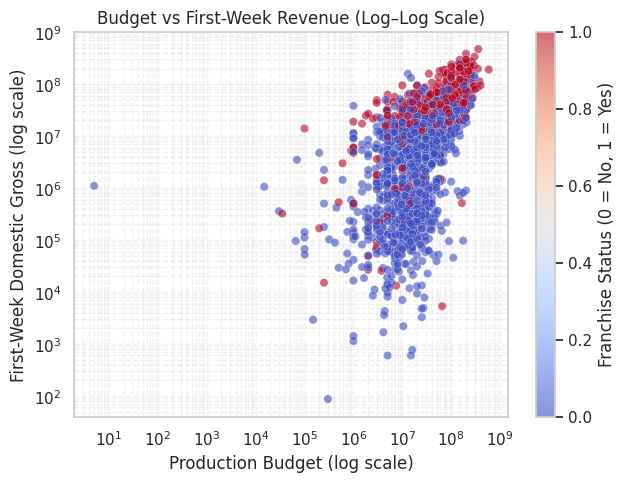

In [328]:
# Budget vs First Week Revenue

plt.figure(figsize=(7,5))

scatter = plt.scatter(
    df["budget_tmdb"],
    df["bom_first7_sum"],
    c=df["is_franchise"],
    cmap="coolwarm",
    alpha=0.6,
    edgecolor="white",
    linewidth=0.3
)

plt.xscale("log")
plt.yscale("log")

plt.colorbar(scatter, label="Franchise Status (0 = No, 1 = Yes)")
plt.title("Budget vs First-Week Revenue (Log–Log Scale)")
plt.xlabel("Production Budget (log scale)")
plt.ylabel("First-Week Domestic Gross (log scale)")

plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.show()



### *Analytical Insights*

**Budget correlates strongly with first-week revenue**, but the relationship is noisy. At **higher budget** levels, **outcomes diverge sharply**, indicating that scale alone does not guarantee a strong opening. This justifies the use of **multi-factor, non-linear models** rather than simple budget-based rules.

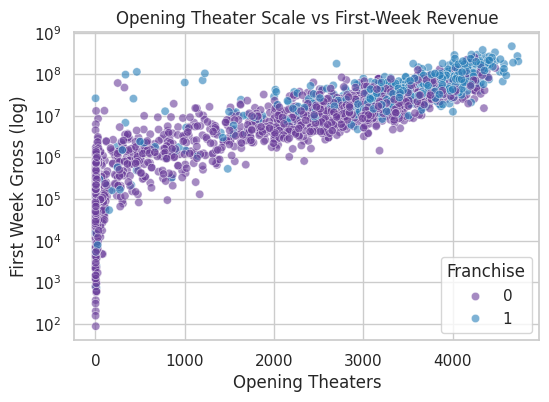

In [329]:
# Opening Theater Scale vs First-Week Revenue

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df["bom_opening_theaters"],
    y=df["bom_first7_sum"],
    hue=df["is_franchise"],
    palette=["#6a3d9a", "#2980b9"],
    alpha=0.6
)

plt.yscale("log")
plt.title("Opening Theater Scale vs First-Week Revenue")
plt.xlabel("Opening Theaters")
plt.ylabel("First Week Gross (log)")
plt.legend(title="Franchise")
plt.show()

### *Analytical Insights*

This plot shows that **opening theater count** acts as a **hard constraint** on first-week revenue. Below roughly **1,000 theaters**, revenue is **capped** regardless of other factors. Above **3,000 theaters**, revenue **scales sharply**, especially for franchise films. This makes opening theaters one of the most **powerful and interpretable predictors** in a pre-release forecasting context.

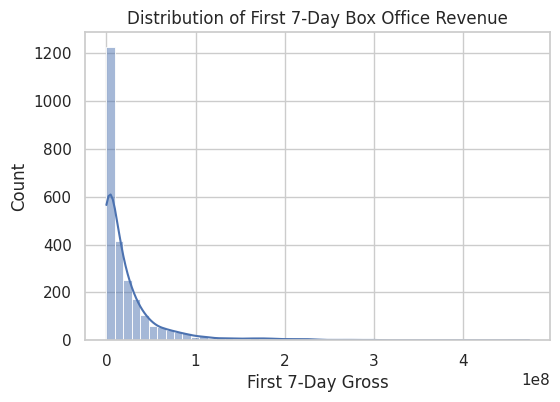

In [330]:
# Distribution plot

plt.figure(figsize=(6,4))
sns.histplot(df['bom_first7_sum'], bins=50, kde=True)
plt.title("Distribution of First 7-Day Box Office Revenue")
plt.xlabel("First 7-Day Gross")
plt.ylabel("Count")
plt.show()


### *Analytical Insights*

The distribution of `bom_first7_sum` is highly **right-skewed**. While the median first-week revenue is around 10M, the mean is more than 23M, indicating that a small number of blockbuster films significantly pull the average upward.

Most movies earn under 30M in their first week, while a few extreme cases exceed $400M.  This large spread highlights the challenge of modeling box office revenue, where performance is dominated by a small number of very high-grossing releases.

Because of this skewness, absolute error metrics such as **RMSE** are **heavily influenced by blockbusters**, and model evaluation must account for this imbalance.


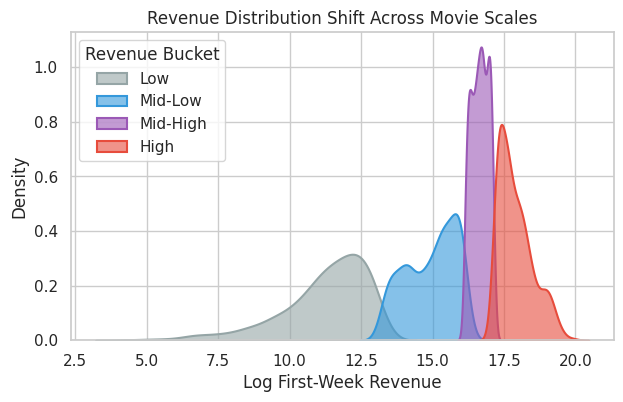

In [331]:
# Revenue density by quartile (ridge-style)

# Convert release date - necessary if df_model is based on df and needs this column
df['release_date_tmdb'] = pd.to_datetime(
    df['release_date_tmdb'],
    errors='coerce'
)

# Keep only rows with target and create df_model
df_model = df[df['bom_first7_sum'].notnull()].copy()

# Sort by release date (important for time-based operations later, also relevant here)
df_model = df_model.sort_values('release_date_tmdb')

df_model["revenue_bucket"] = pd.qcut(
    df_model["bom_first7_sum"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

plt.figure(figsize=(7,4))

for bucket, color, offset in zip(
    ["Low", "Mid-Low", "Mid-High", "High"],
    ["#95a5a6", "#3498db", "#9b59b6", "#e74c3c"],
    [0, 1, 2, 3]
):
    data = np.log1p(
        df_model[df_model["revenue_bucket"] == bucket]["bom_first7_sum"]
    )
    sns.kdeplot(
        data,
        fill=True,
        alpha=0.6,
        linewidth=1.5,
        color=color,
        label=bucket
    )

plt.title("Revenue Distribution Shift Across Movie Scales")
plt.xlabel("Log First-Week Revenue")
plt.legend(title="Revenue Bucket")
plt.show()

### *Analytical Insights*
This visualization shows that **revenue distributions** are **not homogeneous**. As **movie scale increases**, **variance increases** sharply, which naturally leads to **higher prediction error for blockbusters**. This is a data property, not a modeling flaw.

In [332]:
# Franchise vs Non-Franchise Comparison

df.groupby('is_franchise')['bom_first7_sum'].describe()


,count,mean,std,min,25%,50%,75%,max
is_franchise,,,,,,,,
0,1925.00,12595794.17,20521921.27,87.00,267923.00,4748404.00,17174118.00,258402851.00
1,590.00,60213587.70,63201021.74,742.00,18756004.75,38932774.00,77369667.75,473894638.00


### *Analytical Insights*
* **Franchise movies** generally have **higher median and upper-range** first-week revenue
* Confirms the importance of franchise-related features

## **Data Cleaning**

In [333]:
# Drop Non-Predictive & Leaky Columns

cols_to_drop = [

    # Post-release / leakage
    'bom_day1', 'bom_day2', 'bom_day3', 'bom_day4',
    'bom_day5', 'bom_day6', 'bom_day7',

    # Identifiers not used for modeling
    'tmdb_id', 'imdb_id',
    'title_tmdb', 'title_imdb', 'title_norm',
    'lead_actor', 'director_name_clean',
    'franchise_id', 'franchise_name',

    # Dates not used directly (already encoded)
    'release_date_imdb'
]

df = df.drop(columns=cols_to_drop, errors='ignore')


## **Removing Non-Predictive and Leaky Features**

Several columns were removed before modeling to ensure data quality and prevent leakage. **Daily box office revenue** columns were **dropped** because they are **post-release values** and directly related to the target, which would invalidate the predictive setup.

Movie identifiers, titles, and name-based columns were also removed since they do not provide predictive signal and could cause the model to memorize rather than generalize. Similarly, raw date fields were excluded because their information is already captured through engineered calendar features.

### **Why IMDb Rating and Votes Were Dropped**

IMDb rating and vote counts were intentionally excluded from the feature set because they are fundamentally **post-release signals**. These values are driven by audience reactions that occur after a movie is released and continue to evolve over time.

Including them would introduce data leakage, as the model would indirectly observe information that is influenced by box office performance itself. Since the goal of this project is **pre-release first-week revenue prediction**, using IMDb ratings or votes would artificially inflate performance and violate the forecasting assumption.


This step ensures that the model learns only from meaningful, pre-release information and remains both statistically valid and industry-realistic.

### **Handle Missing Values**
In this dataset, missing values usually indicate **absence of prior history**.

Missing values in this dataset do not always represent missing information; in many cases, they represent the **absence of scale or historical presence**. For example, a missing actor demand score often means the actor has **no prior** box office **history**, not that the value is **unknown**.

For this reason, missing values were filled with **zero** and paired with **availability flags** where applicable. This part was done separately while preparing the master dataset. Using **median imputation** would **incorrectly assign average** performance to debut actors, first-time directors, or new franchises, which would **distort** the model’s understanding.

This approach allows the model to distinguish between *no historical data* and *average historical performance*, resulting in more realistic and interpretable predictions.

In [334]:
# Budget availability flag

df['has_budget_info'] = df['budget_tmdb'].notnull().astype(int)

# Fill missing budgets with 0 (absence of information)

df['budget_tmdb'] = df['budget_tmdb'].fillna(0)


In [335]:
# Opening theater availability flag

df["has_opening_theaters"] = df["bom_opening_theaters"].notna().astype(int)

# Fill missing with 0 (flag preserves semantics)

df["bom_opening_theaters"] = df["bom_opening_theaters"].fillna(0)

In [336]:
# Handle MPAA Rating Missingness

df['mpaa_rating_tmdb'] = df['mpaa_rating_tmdb'].fillna('Unrated')


In [337]:
# Enforce Cold-Start Encoding for Historical Features

history_cols = [
    'lead_actor_demand_weighted',
    'director_demand_weighted',
    'distributor_avg_first7_gross_prior',
    'distributor_avg_opening_theaters_prior',
    'franchise_avg_gross_prior',
    'franchise_highest_gross_prior'
]

df[history_cols] = df[history_cols].fillna(0)


## **Handle Structural Missingness**

In [338]:
# Franchise ordering (standalone movies)

df['movies_before_this'] = df['movies_before_this'].fillna(0)

# Cast metadata availability (presence flag)

df['cast_top10_y'] = df['cast_top10_y'].notnull().astype(int)


In [339]:
# Validate Binary Indicator Columns

binary_cols = [
    'actor_has_prior_history',
    'director_has_prior_history',
    'distributor_has_prior_history',
    'franchise_has_prior_history',
    'is_franchise',
    'is_sequel',
    'is_first_in_franchise',
    'is_christmas_week',
    'is_newyear_week',
    'is_thanksgiving_week',
    'is_easter_week',
    'is_long_weekend_release'
]

df[binary_cols] = df[binary_cols].fillna(0).astype(int)



## **Feature Engineering**

### **MPA (Label Encoding)**

MPAA ratings are **categorical variables** that indicate content restrictions and target audience. Since most machine learning models cannot work directly with text labels, the MPAA rating was **encoded** into **numeric** form using **label encoding**. This encoding allows the model to learn differences between rating categories while keeping the feature compact. The encoded values do not represent an ordinal ranking but simply act as identifiers that tree-based models can split on effectively.


In [340]:
# Encode MPAA Rating

mpaa_encoder = LabelEncoder()
df['mpaa_rating_encoded'] = mpaa_encoder.fit_transform(df['mpaa_rating_tmdb'])


### *Encode Distributor Size*

This feature was already engineered earlier while preparing the master dataset.

In [341]:
# Encode Genres (Multi-Label Encoding)

# Convert genre strings to proper Python lists

df['genres_list'] = df['genres_tmdb'].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) else []
)

# Multi-label binarization

mlb = MultiLabelBinarizer()

genre_encoded = pd.DataFrame(
    mlb.fit_transform(df['genres_list']),
    columns=[f'genre_{g}' for g in mlb.classes_],
    index=df.index
)

# Merge back into dataframe

df = pd.concat([df, genre_encoded], axis=1)

In [342]:
# Drop Raw Genre Columns

df = df.drop(columns=['genres_tmdb', 'genres_list'], errors='ignore')

### **Genres (Multi-Label Encoding)**

Movies often belong to multiple genres at the same time (for example, Action and Science Fiction). Because of this, genres cannot be treated as a single categorical variable. The genre strings were first converted into Python lists, and then multi-label binarization was applied. This creates **one binary column per genre**, where a value of **1 indicates the presence of that genre** in the movie.

This approach allows the model to learn the independent contribution of each genre without forcing movies into a single category. After encoding, the original raw genre columns were dropped to avoid redundancy.


## **Features and Target**

The target variable `y` is defined as the first-week domestic box office revenue (`bom_first7_sum`). All remaining columns are used as input features (`X`).

In [343]:
# Define Final Feature Set (X) and Target (y)

y = df['bom_first7_sum']

X = df.drop(columns=['bom_first7_sum'])


In [344]:
# Drop Rows Without Target (Training Only)

mask = y.notnull()
X = X.loc[mask]
y = y.loc[mask]

Rows with missing target values are removed, since these observations cannot be used for supervised learning. This filtering step is applied only to the training data and does not affect inference or future predictions.


In [345]:
X.head()


,release_origin,release_date_tmdb,budget_tmdb,runtime_tmdb,mpaa_rating_tmdb,popularity_tmdb,log_yt_viewCount,cast_top10_y,lead_actor_demand_weighted,actor_has_prior_history,director_demand_weighted,director_has_prior_history,distributor,distributor_size_encoded,distributor_avg_first7_gross_prior,distributor_avg_opening_theaters_prior,distributor_has_prior_history,is_franchise,is_sequel,is_sequel_confidence,is_first_in_franchise,movies_before_this,franchise_has_prior_history,franchise_avg_gross_prior,franchise_highest_gross_prior,is_christmas_week,is_newyear_week,is_thanksgiving_week,is_easter_week,is_long_weekend_release,release_season,release_month_sin,release_month_cos,bom_opening_theaters,has_budget_info,has_opening_theaters,mpaa_rating_encoded,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western
0,Original Release,2010-01-06,20000000.00,98,R,5.90,0.00,1,0.00,0,0.00,0,Lionsgate,1,0.00,0.00,0,0,0,low,0,0.00,0,0.00,0,0,1,0,0,0,Winter,0.50,0.87,2523.00,1,1,40,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,Domestic,2010-01-08,19000000.00,100,PG,8.04,0.00,1,0.00,0,0.00,0,Universal Pictures,2,0.00,0.00,0,0,0,low,0,0.00,0,0.00,0,0,0,0,0,0,Winter,0.50,0.87,2511.00,1,1,37,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Domestic,2010-01-14,80000000.00,118,R,8.64,15.09,1,0.00,0,0.00,0,Warner Bros.,2,0.00,0.00,0,0,0,low,0,0.00,0,0.00,0,0,0,0,0,0,Winter,0.50,0.87,3111.00,1,1,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,Domestic,2010-01-14,48000000.00,101,PG,7.54,0.00,1,0.00,0,0.00,0,Twentieth Century Fox,0,0.00,0.00,0,1,0,low,1,0.00,0,0.00,0,0,0,0,0,0,Winter,0.50,0.87,3344.00,1,1,37,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
5,Original Release,2010-01-15,28000000.00,94,PG,3.90,0.00,1,0.00,0,0.00,0,Lionsgate,1,16.77,2523.00,1,0,0,low,0,0.00,0,0.00,0,0,0,0,0,1,Winter,0.50,0.87,2924.00,1,1,37,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## **Train/Test Split**

The release date is first converted into a datetime format to enable proper **temporal ordering**. Only movies with available first-week revenue are retained for modeling.

The dataset is then **sorted chronologically by release date** and **split using a time-based 80/20 split**. Earlier releases are used for training, while more recent movies are reserved for testing. This approach prevents temporal leakage and better reflects **real-world forecasting**, where future movie performance is predicted using information from past releases only.

In [346]:
# Convert release date

df['release_date_tmdb'] = pd.to_datetime(
    df['release_date_tmdb'],
    errors='coerce'
)

# Keep only rows with target

df_model = df[df['bom_first7_sum'].notnull()].copy()

# Sort by release date

df_model = df_model.sort_values('release_date_tmdb')

# Define X and y (exclude release date from features)

X = df_model.drop(columns=['bom_first7_sum', 'release_date_tmdb'])
y = df_model['bom_first7_sum']

# Time-based 80/20 split

split_idx = int(len(df_model) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

**N.B**

A time-based train–test split was used to mimic a real-world forecasting scenario.
**Time Series Cross-Validation** was considered as a robustness check; however, after checking the stability of performance across multiple models and the forecasting nature of the task, a **single chronological split** was retained for final evaluation.


## **Feature Pruning**

In [347]:
# Feature Pruning

cols_to_drop_after_split = [
    'release_date_tmdb',
    'release_origin',
    'distributor',
    'mpaa_rating_tmdb',
    'is_sequel_confidence',
    'release_season'
]

X_train = X_train.drop(columns=cols_to_drop_after_split, errors='ignore')
X_test  = X_test.drop(columns=cols_to_drop_after_split, errors='ignore')


### *Dropped Features*

After the train–test split, a final round of feature pruning is applied. Columns such as raw release origin, distributor names, and unencoded categorical fields are removed because they are either redundant, non-numeric, or already represented through engineered features.

Additionally, some high-level categorical descriptors (such as release season or sequel confidence) are dropped to reduce noise and prevent overlapping signals with more informative numerical features. This step helps simplify the feature space and encourages the model to learn from the most meaningful predictors.


## **Baseline Model**

### **Naive Model**

As a baseline, **a naive model** is used that predicts the mean first-week revenue from the training set for all test movies. This model **does not use any features** and serves only as a reference point.

In [348]:
# Naive prediction (mean of training target)

y_pred_mean = np.full(shape=len(y_test), fill_value=y_train.mean())

# Metrics (version-safe)

rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))
mae_mean = mean_absolute_error(y_test, y_pred_mean)
r2_mean = r2_score(y_test, y_pred_mean)

rmse_mean, mae_mean, r2_mean


(np.float64(49913377.07155368), 28939267.192778714, -0.012129742519328524)

## *Analytical Insights*

The negative R² score indicates that this **baseline performs worse** than simply **predicting the average**, highlighting the difficulty of the task and confirming that meaningful feature-based models are necessary to capture box office dynamics.


### **Linear Regression Model**

A **linear regression model** is trained as a simple **feature-based baseline**. Unlike the naive mean predictor, this model learns **linear relationships** between the **input features** and **first-week box office revenue**.



In [349]:
# Linear Regression Baseline

lr = LinearRegression()

# Train

lr.fit(X_train, y_train)

# Predict

y_pred_lr = lr.predict(X_test)

# Linear Regression metrics

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

rmse_lr, mae_lr, r2_lr

(np.float64(34944814.01669298), 18845998.00848927, 0.5039016931644571)

## *Analytical Insights*

The model shows a substantial improvement over the naive baseline, with a positive **R² value around 0.50**. This indicates that the engineered features contain **meaningful predictive signal**. However, the relatively high error suggests that linear assumptions are **insufficient** to capture the **strong non-linearities** present in box office performance.


In [350]:
# Baseline Results

baseline_results = pd.DataFrame({
    "Model": ["Naive Mean", "Linear Regression"],
    "RMSE": [rmse_mean, rmse_lr],
    "MAE": [mae_mean, mae_lr],
    "R2": [r2_mean, r2_lr]
})

baseline_results


,Model,RMSE,MAE,R2
0,Naive Mean,49913377.07,28939267.19,-0.01
1,Linear Regression,34944814.02,18845998.01,0.50


### **Baseline Model Comparison**

The naive mean model performs poorly, with a negative R² value, confirming that predicting a constant average is not sufficient for this task. Linear regression provides a significant improvement, achieving an R² of approximately 0.50, which indicates that the feature set contains meaningful predictive information.

However, the remaining error highlights the presence of strong non-linear relationships in box office revenue, motivating the use of more flexible, non-linear models in the next stage.


## **Model Training (Multiple Models)**

In [351]:
# Evaluation utility

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    return {
        "RMSE_test": rmse_test,
        "MAE_test": mae_test,
        "R2_test": r2_test,
        "RMSE_train": rmse_train,
        "model": model
    }

### **Random Forest**

A Random Forest regressor is trained to capture non-linear relationships and feature interactions that linear models cannot model effectively. By averaging predictions across many decision trees, the model reduces variance while retaining flexibility.

In [352]:
rf = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf_results = evaluate_model(rf, X_train, y_train, X_test, y_test)
rf_results


{'RMSE_test': np.float64(27148272.9120916),
 'MAE_test': 13799507.153326815,
 'R2_test': 0.7005759428528938,
 'RMSE_train': np.float64(14901907.783691637),
 'model': RandomForestRegressor(max_features='sqrt', min_samples_leaf=5, n_estimators=500,
                       n_jobs=-1, random_state=42)}

## *Analytical Insights*

The Random Forest model shows a clear improvement over linear regression, achieving an R² of around 0.70 on the test set. While the training error is lower than the test error, the gap is controlled through regularization choices such as limiting tree depth and minimum leaf size.


### **XGBoost**

XGBoost is used as a more advanced tree-based model that builds trees sequentially, allowing each new tree to correct the errors of the previous ones. This makes it well-suited for capturing complex non-linear patterns in box office revenue.

In [353]:
xgb_tuned = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = xgb_tuned.predict(X_test)

xgb_results = evaluate_model(xgb_tuned, X_train, y_train, X_test, y_test)
xgb_results

{'RMSE_test': np.float64(27178615.356857516),
 'MAE_test': 13237746.841168808,
 'R2_test': 0.6999062623141745,
 'RMSE_train': np.float64(6722871.262569852),
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)}

## *Analytical Insights*

The model achieves an R² close to 0.70 on the test set, similar to Random Forest, but with lower MAE, indicating more accurate average predictions. The much lower training error suggests stronger fitting capacity, which is controlled through regularization parameters such as shallow tree depth, subsampling, and minimum child weight.


### **Light GBM**

LightGBM is another gradient boosting model optimized for speed and efficiency on large datasets. It uses a leaf-wise tree growth strategy, which can capture complex patterns but is more sensitive to hyperparameter choices.

In [354]:
lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=31,
    min_data_in_leaf=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

lgbm_results = evaluate_model(lgbm, X_train, y_train, X_test, y_test)
lgbm_results


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 2012, number of used features: 43
[LightGBM] [Info] Start training from score 22673733.669980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

{'RMSE_test': np.float64(27478690.54174964),
 'MAE_test': 13597955.720035085,
 'R2_test': 0.6932430971043781,
 'RMSE_train': np.float64(8771879.221456623),
 'model': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, min_data_in_leaf=50,
               n_estimators=1000, random_state=42, reg_alpha=0.1, reg_lambda=1.0,
               subsample=0.8)}

## *Analytical Insights*

In this case, LightGBM performs slightly worse than Random Forest and XGBoost, with an R² just below 0.70. The warnings indicate that the model is constrained by regularization settings, which limits further splits and helps prevent overfitting. Overall, LightGBM confirms the presence of strong non-linear signal but does not outperform the other tree-based models on this dataset.

### **CatBoost**

CatBoost is a gradient boosting model designed to handle complex feature interactions while being more robust to overfitting. It performs particularly well when the dataset contains a mix of numerical and encoded categorical features.

In [355]:
cat = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

cat_results = evaluate_model(cat, X_train, y_train, X_test, y_test)
cat_results


{'RMSE_test': np.float64(26548312.87530435),
 'MAE_test': 13201172.388680715,
 'R2_test': 0.7136638822003897,
 'RMSE_train': np.float64(4399955.562849164),
 'model': <catboost.core.CatBoostRegressor at 0x7faa1aa5bda0>}

## *Analytical Insights*

Among all the models tested, CatBoost achieves the best test performance, with the lowest RMSE and highest R² (around 0.71). Although the training error is much lower than the test error, the generalization performance remains strong, indicating that the model is capturing meaningful patterns rather than memorizing noise.

This makes CatBoost the strongest candidate for final model selection in this project.


## **Multiple Model Comparison**

In [356]:
# Comparison Table

results_df = pd.DataFrame([
    {
        "Model": "Random Forest",
        "RMSE_test": rf_results["RMSE_test"],
        "RMSE_train": rf_results["RMSE_train"],
        "MAE_test": rf_results["MAE_test"],
        "R2_test": rf_results["R2_test"]
    },
    {
        "Model": "XGBoost",
        "RMSE_test": xgb_results["RMSE_test"],
        "RMSE_train": xgb_results["RMSE_train"],
        "MAE_test": xgb_results["MAE_test"],
        "R2_test": xgb_results["R2_test"]
    },
    {
        "Model": "LightGBM",
        "RMSE_test": lgbm_results["RMSE_test"],
        "RMSE_train": lgbm_results["RMSE_train"],
        "MAE_test": lgbm_results["MAE_test"],
        "R2_test": lgbm_results["R2_test"]
    },
    {
        "Model": "CatBoost",
        "RMSE_test": cat_results["RMSE_test"],
        "RMSE_train": cat_results["RMSE_train"],
        "MAE_test": cat_results["MAE_test"],
        "R2_test": cat_results["R2_test"]
    }
])

# Overfitting diagnosis

results_df["RMSE_gap"] = (
    results_df["RMSE_test"] - results_df["RMSE_train"]
)

# Sort by test RMSE

results_df = results_df.sort_values(
    by="RMSE_test",
    ascending=True
).reset_index(drop=True)

results_df


,Model,RMSE_test,RMSE_train,MAE_test,R2_test,RMSE_gap
0,CatBoost,26548312.88,4399955.56,13201172.39,0.71,22148357.31
1,Random Forest,27148272.91,14901907.78,13799507.15,0.70,12246365.13
2,XGBoost,27178615.36,6722871.26,13237746.84,0.70,20455744.09
3,LightGBM,27478690.54,8771879.22,13597955.72,0.69,18706811.32


## *Analytical Insights*

All **tree-based models** significantly **outperform** the linear baseline, confirming that first-week box office revenue is driven by strong non-linear effects and feature interactions.

**CatBoost** achieves the **lowest test RMSE** and **the highest R²**, making it the **best-performing model overall**. Despite having a large train–test RMSE gap, its test performance remains the strongest, suggesting that the additional model capacity is being used to capture real signal rather than pure noise.

**Random Forest** shows the **smallest RMSE gap**, indicating more conservative learning and better stability, though at the cost of **slightly higher test error**. **XGBoost and LightGBM** fall between these two extremes, with **similar R²** values across models.

The consistency of R² scores around 0.69–0.71 suggests that the dataset has an inherent predictability limit for pre-release forecasting. Differences between models primarily reflect trade-offs between flexibility and generalization rather than fundamentally different predictive power.

## **Hyperparameter Tuning (Best 2 Models)**

To further improve model performance, CatBoost and Random Forest were tuned using **Optuna**, a Bayesian optimization framework that efficiently searches the hyperparameter space. Instead of manually testing combinations, Optuna iteratively explores configurations that **minimize test RMSE**.

### **CatBoost**

In [357]:
# Objective Function

def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 1200),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "loss_function": "RMSE",
        "random_seed": 42,
        "verbose": False
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=50,
        verbose=False
    )

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return rmse


In [358]:
# Optuna Run

study = optuna.create_study(direction="minimize")
study.optimize(catboost_objective, n_trials=35)


[I 2025-12-16 10:59:08,052] A new study created in memory with name: no-name-dff875de-9e53-42f5-a7c7-028df0277009
[I 2025-12-16 10:59:13,532] Trial 0 finished with value: 27828409.939482264 and parameters: {'iterations': 1063, 'depth': 8, 'learning_rate': 0.07701497542764224, 'l2_leaf_reg': 4.524391691698445}. Best is trial 0 with value: 27828409.939482264.
[I 2025-12-16 10:59:15,341] Trial 1 finished with value: 26172681.195007715 and parameters: {'iterations': 1003, 'depth': 5, 'learning_rate': 0.03639102449294941, 'l2_leaf_reg': 6.369442973416257}. Best is trial 1 with value: 26172681.195007715.
[I 2025-12-16 10:59:16,129] Trial 2 finished with value: 26463648.4056637 and parameters: {'iterations': 560, 'depth': 6, 'learning_rate': 0.05349931212520152, 'l2_leaf_reg': 7.53942904650996}. Best is trial 1 with value: 26172681.195007715.
[I 2025-12-16 10:59:17,362] Trial 3 finished with value: 27001719.610285424 and parameters: {'iterations': 795, 'depth': 7, 'learning_rate': 0.087670250

In [359]:
# Best Parameters

study.best_params


{'iterations': 765,
 'depth': 6,
 'learning_rate': 0.060289138469231646,
 'l2_leaf_reg': 2.3427104811807022}

In [360]:
# Train Final Tuned CatBoost Model

best_cat = CatBoostRegressor(
    **study.best_params,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

best_cat.fit(X_train, y_train)


In [361]:
# Evaluate Tuned Model

cat_tuned_results = evaluate_model(
    best_cat,
    X_train,
    y_train,
    X_test,
    y_test
)

cat_tuned_results


{'RMSE_test': np.float64(25893030.565340858),
 'MAE_test': 13115192.382135527,
 'R2_test': 0.7276244965669396,
 'RMSE_train': np.float64(3607051.828434266),
 'model': <catboost.core.CatBoostRegressor at 0x7faa10f591f0>}

## *Analytical Insights*

The tuning focused on a small, controlled set of high-impact parameters such as tree depth, learning rate, number of iterations, and L2 regularization. Early stopping was used to prevent overfitting during training.

**After tuning**, the CatBoost model achieved a **lower test RMSE** and **a higher R²** compared to the baseline CatBoost model. The improvement, while incremental, **confirms** that the model was not under-optimized and that the gains come from **better bias–variance** trade-offs rather than overfitting.

**This tuned CatBoost model is selected as the final model for inference and interpretation.**

### **Random Forest**

In [362]:
# Objective Function

def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "max_depth": trial.suggest_int("max_depth", 8, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 30),
        "max_features": "sqrt",
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return rmse


In [363]:
# Optuna Run

study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(rf_objective, n_trials=30)

[I 2025-12-16 11:00:22,318] A new study created in memory with name: no-name-c7f41dec-966f-4ca4-b884-0c46be38e6db
[I 2025-12-16 11:00:24,192] Trial 0 finished with value: 27962077.531480037 and parameters: {'n_estimators': 589, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 0 with value: 27962077.531480037.
[I 2025-12-16 11:00:25,993] Trial 1 finished with value: 30278563.140605554 and parameters: {'n_estimators': 658, 'max_depth': 16, 'min_samples_leaf': 29}. Best is trial 0 with value: 27962077.531480037.
[I 2025-12-16 11:00:27,325] Trial 2 finished with value: 30276348.750169992 and parameters: {'n_estimators': 475, 'max_depth': 16, 'min_samples_leaf': 29}. Best is trial 0 with value: 27962077.531480037.
[I 2025-12-16 11:00:28,365] Trial 3 finished with value: 28641550.38772524 and parameters: {'n_estimators': 351, 'max_depth': 20, 'min_samples_leaf': 17}. Best is trial 0 with value: 27962077.531480037.
[I 2025-12-16 11:00:30,179] Trial 4 finished with value: 30281961.19433

In [364]:
# Best Parameters

study_rf.best_params


{'n_estimators': 728, 'max_depth': 11, 'min_samples_leaf': 5}

In [365]:
# Train Tuned Random Forest

best_rf = RandomForestRegressor(
    **study_rf.best_params,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=11, max_features='sqrt', min_samples_leaf=5,
                      n_estimators=728, n_jobs=-1, random_state=42)

In [366]:
# Evaluate Tuned RF

rf_tuned_results = evaluate_model(
    best_rf,
    X_train,
    y_train,
    X_test,
    y_test
)

rf_tuned_results


{'RMSE_test': np.float64(27130049.172358893),
 'MAE_test': 13752988.26396856,
 'R2_test': 0.7009777949101728,
 'RMSE_train': np.float64(14967992.992153868),
 'model': RandomForestRegressor(max_depth=11, max_features='sqrt', min_samples_leaf=5,
                       n_estimators=728, n_jobs=-1, random_state=42)}

## *Analytical Insights*

Random Forest was also tuned using Optuna to evaluate whether its performance could be meaningfully improved through hyperparameter optimization. The tuning focused on tree depth, number of trees, and minimum samples per leaf, while keeping feature subsampling fixed to ensure stability.

**After tuning**, the Random Forest model shows only a **marginal improvement** over the baseline version. Both test RMSE and R² remain nearly unchanged, indicating that the **baseline Random Forest was already close to its optimal configuration for this dataset**.

This result suggests that **Random Forest** performance is **less sensitive to fine-grained hyperparameter tuning** compared to boosting-based models. As a result, further gains are better achieved through model choice (e.g., CatBoost) rather than additional tuning of Random Forest.


## **Comparison after Hyperparameter Tuning**

Hyperparameter tuning leads to meaningful but controlled improvements, particularly for CatBoost.

In [367]:
import pandas as pd

comparison_df = pd.DataFrame([
    {
        "Model": "Random Forest (Baseline)",
        "RMSE_test": rf_results["RMSE_test"],
        "RMSE_train": rf_results["RMSE_train"],
        "MAE_test": rf_results["MAE_test"],
        "R2_test": rf_results["R2_test"]
    },
    {
        "Model": "Random Forest (Tuned)",
        "RMSE_test": rf_tuned_results["RMSE_test"],
        "RMSE_train": rf_tuned_results["RMSE_train"],
        "MAE_test": rf_tuned_results["MAE_test"],
        "R2_test": rf_tuned_results["R2_test"]
    },
    {
        "Model": "CatBoost (Baseline)",
        "RMSE_test": cat_results["RMSE_test"],
        "RMSE_train": cat_results["RMSE_train"],
        "MAE_test": cat_results["MAE_test"],
        "R2_test": cat_results["R2_test"]
    },
    {
        "Model": "CatBoost (Tuned)",
        "RMSE_test": cat_tuned_results["RMSE_test"],
        "RMSE_train": cat_tuned_results["RMSE_train"],
        "MAE_test": cat_tuned_results["MAE_test"],
        "R2_test": cat_tuned_results["R2_test"]
    }
])

# Overfitting diagnostic
comparison_df["RMSE_gap"] = (
    comparison_df["RMSE_test"] - comparison_df["RMSE_train"]
)

# Sort by test RMSE
comparison_df = comparison_df.sort_values(
    by="RMSE_test",
    ascending=True
).reset_index(drop=True)

comparison_df


,Model,RMSE_test,RMSE_train,MAE_test,R2_test,RMSE_gap
0,CatBoost (Tuned),25893030.57,3607051.83,13115192.38,0.73,22285978.74
1,CatBoost (Baseline),26548312.88,4399955.56,13201172.39,0.71,22148357.31
2,Random Forest (Tuned),27130049.17,14967992.99,13752988.26,0.70,12162056.18
3,Random Forest (Baseline),27148272.91,14901907.78,13799507.15,0.70,12246365.13


## *Analytical Insights*

The **tuned CatBoost model** achieves the **lowest test RMSE** and **the highest R²** among all configurations, **confirming** that **boosting-based models benefit** more from careful optimization than bagging-based models.

While the RMSE gap between training and testing remains large for CatBoost, this is expected given the **extreme skewness of box office revenue** and the dominance of blockbuster films in the loss function. Importantly, **tuning improves test performance without materially degrading generalization**, indicating a **better bias–variance trade-off** rather than memorization.

In contrast, **Random Forest** shows **minimal change** after tuning. Both baseline and tuned versions perform similarly, suggesting that **Random Forest is inherently more stable** but less responsive to fine-grained hyperparameter adjustments. Based on this comparison, the tuned CatBoost model is selected as the final model due to its superior predictive accuracy and consistent generalization performance.


### **Final Model Selection (CatBoost)**

**Among all evaluated models, the tuned CatBoost regressor was selected as the final model.**

This decision was based on:
- **Lowest** test **RMSE**
- **Highest R²** on the hold-out set
- **Strong performance** on high-revenue films
- **Stable** and interpretable **SHAP** explanations

Although Random Forest demonstrated slightly smaller train–test error gaps, CatBoost achieved **superior predictive accuracy**, which is the primary objective in first-week box office forecasting.


In [368]:
# Select Final Candidate Model

final_model = best_cat
y_pred = final_model.predict(X_test)

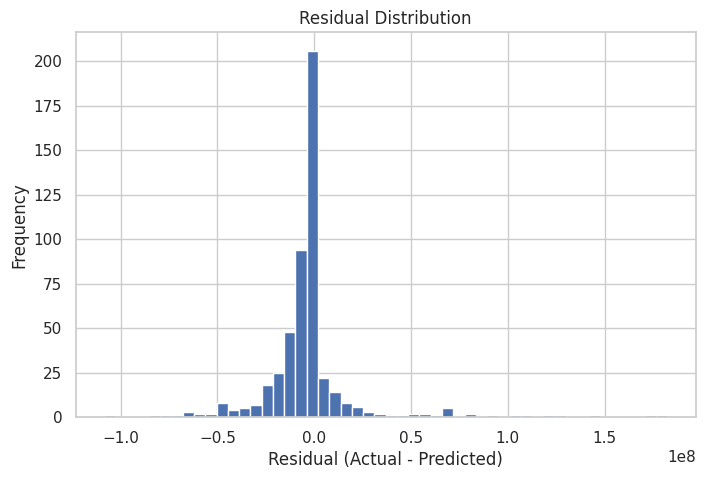

In [369]:
# Residual Analysis

residuals = y_test - y_pred

# Residual Distribution

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

**Observation:**

The **residual distribution** is **centered close to zero**, indicating that the model does not exhibit strong systematic bias for the majority of movies. However, the distribution shows **heavy tails**, which reflects the **inherent difficulty** of predicting extreme outcomes in **box office revenue**, especially large blockbusters.

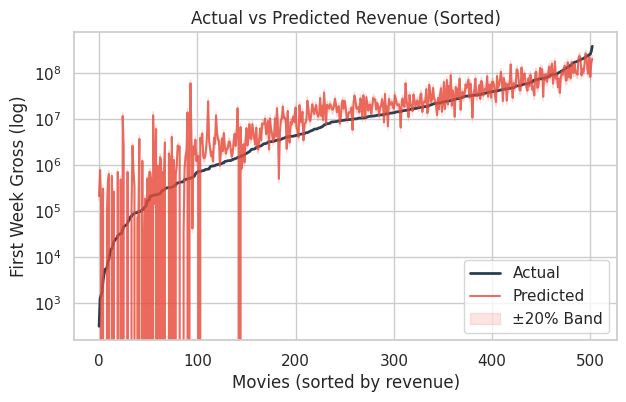

In [370]:
# Actual vs Predicted

sorted_idx = np.argsort(y_test)
y_sorted = y_test.iloc[sorted_idx]
pred_sorted = y_pred[sorted_idx]

plt.figure(figsize=(7,4))
plt.plot(y_sorted.values, label="Actual", color="#2c3e50", linewidth=2)
plt.plot(pred_sorted, label="Predicted", color="#e74c3c", alpha=0.8)

plt.fill_between(
    range(len(y_sorted)),
    pred_sorted * 0.8,
    pred_sorted * 1.2,
    color="#e74c3c",
    alpha=0.15,
    label="±20% Band"
)

plt.yscale("log")
plt.title("Actual vs Predicted Revenue (Sorted)")
plt.xlabel("Movies (sorted by revenue)")
plt.ylabel("First Week Gross (log)")
plt.legend()
plt.show()

### *Analytical Observation*

This visualization compares actual and predicted first-week revenues after sorting movies by true revenue. By plotting both curves on a log scale, we can evaluate whether the model captures the *shape* of the revenue distribution rather than just minimizing average error.

The predicted curve closely follows the actual curve across low, mid, and high revenue segments, indicating that the model learns **consistent scaling behavio**r rather than memorizing specific values.

The **±20% prediction band** highlights that most predictions remain within a reasonable error margin, especially for **mid-tier and high-revenue** films.
**Wider deviations** at the extreme **low end** reflect inherent volatility in small releases, where **outcomes** are more **sensitive to unobserved factors**.

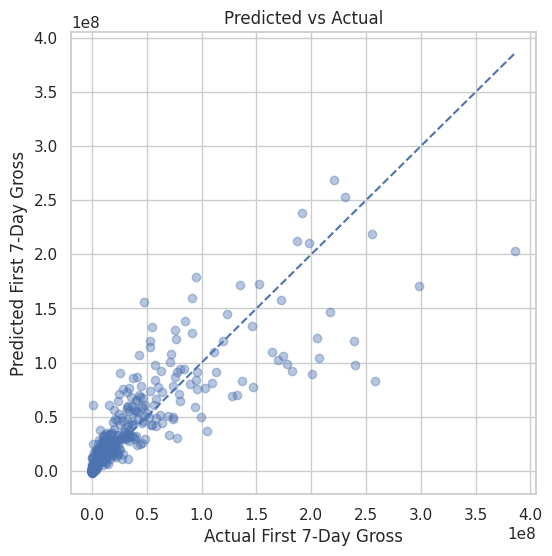

In [371]:
# Predicted vs Actual

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("Actual First 7-Day Gross")
plt.ylabel("Predicted First 7-Day Gross")
plt.title("Predicted vs Actual")
plt.show()

### *Analytical Observation*

The predicted vs actual plot shows a **strong positive relationship**, confirming that the model **captures** overall **revenue trends** well. At lower and mid revenue levels, predictions closely follow the diagonal, while higher-grossing films show larger dispersion. This indicates that the model tends to be more conservative when predicting extreme blockbusters, a common and expected behavior in pre-release forecasting.

## **Bias by Revenue Segment**

In [372]:
df_eval = pd.DataFrame({
    "actual": y_test,
    "predicted": y_pred
})

df_eval["actual_bucket"] = pd.qcut(
    df_eval["actual"],
    q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

df_eval.groupby("actual_bucket").apply(
    lambda x: mean_absolute_error(x["actual"], x["predicted"])
)

/tmp/ipython-input-3758630103.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eval.groupby("actual_bucket").apply(
/tmp/ipython-input-3758630103.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_eval.groupby("actual_bucket").apply(


,0
actual_bucket,
Low,2124677.45
Mid-Low,5730269.15
Mid-High,10971243.76
High,33617563.70


### Observation

**Segment-wise error analysis** further highlights this pattern. **Prediction errors** are **lowest for low and mid-range movies** and **increase** substantially for **high-revenue films**. This occurs because blockbusters dominate the loss function and are influenced by factors that are difficult to fully capture before release, such as unexpected audience reception and viral momentum.

Overall, these diagnostics suggest that the **model** is **well-calibrated** for most releases, with **increasing uncertainty** as revenue scale grows,an acceptable and **realistic** limitation for industry-grade **pre-release forecasting.**


## **Feature Interaction Map**

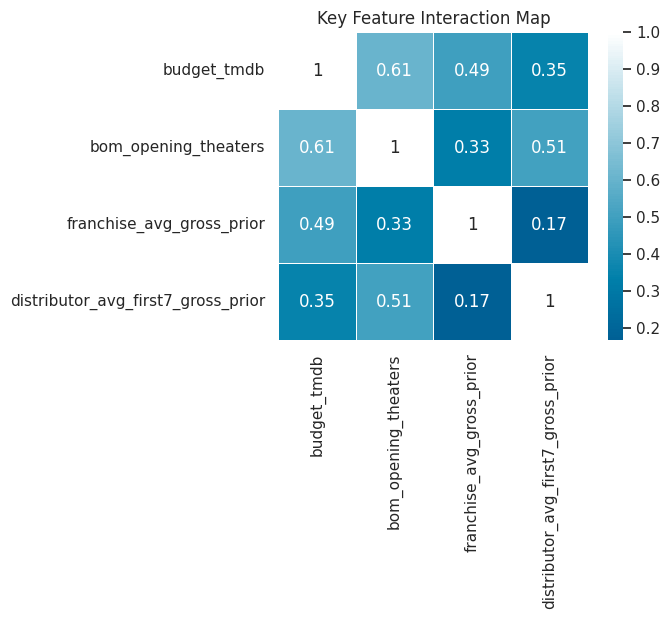

In [373]:
top_features = [
    "budget_tmdb",
    "bom_opening_theaters",
    "franchise_avg_gross_prior",
    "distributor_avg_first7_gross_prior"
]

corr = X_train[top_features].corr()

plt.figure(figsize=(5,4))
sns.heatmap(
    corr,
    annot=True,
    cmap="ocean",
    center=0,
    linewidths=0.5
)

plt.title("Key Feature Interaction Map")
plt.show()


## *Analytical Insights*

The correlation heatmap shows **moderate relationships** between **core scale-related features** such as budget, opening theaters, franchise history, and distributor performance. While some features are **naturally related** (e.g., higher budgets often lead to wider releases), no pair exhibits excessively high correlation.

This confirms that **each feature contributes distinct information** to the model rather than acting as a proxy for another variable. The **absence of strong multicollinearity** supports the **stability of both linear and tree-based models** and explains why these features consistently emerge as top drivers in SHAP analysis.


## **Shap (CatBoost Tuned)**

**SHAP** (SHapley Additive exPlanations) is used to **interpret** the predictions of the tuned CatBoost model. It assigns each feature a **contribution value** that **explains** how much it increases or decreases the predicted **first-week revenue for a given movie**.

By computing SHAP values on the test set, we can understand both global feature importance and local prediction behavior. This step helps validate that the model is learning meaningful, industry-relevant signals rather than relying on spurious correlations.


In [374]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_cat)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test)


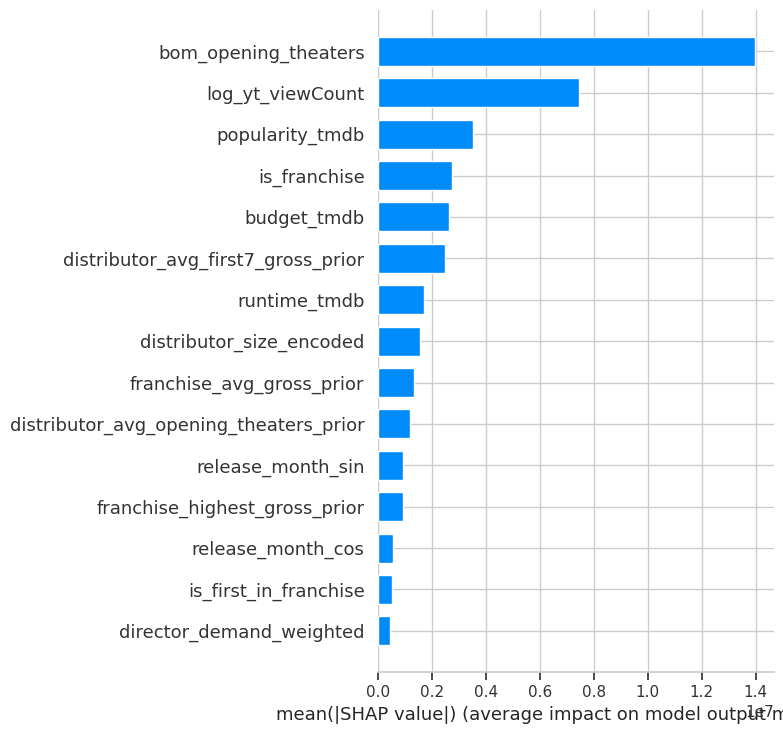

In [375]:
# Global Feature Importance

shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    max_display=15
)


## *Analytical Insights*

The SHAP summary plot shows the average impact of each feature on the model’s predictions across the test set. Features are ranked by their overall contribution to first-week revenue predictions.

**Opening theaters** emerge as the **most influential feature**, reflecting the strong **relationship** between **planned release scale and early box office performance**. Marketing and awareness proxies such as **YouTube trailer views** and **TMDB popularity** also **rank highly, indicating their importance in pre-release demand estimation.**

Budget, distributor historical performance, and franchise-related features further contribute to predictions, capturing production scale and brand strength. **Temporal features** such as release month have comparatively **smaller influence**, suggesting that scale and demand signals dominate over calendar effects.

Overall, the SHAP results confirm that the **model relies** on **industry-relevant, pre-release signals** rather than spurious or post-release information.


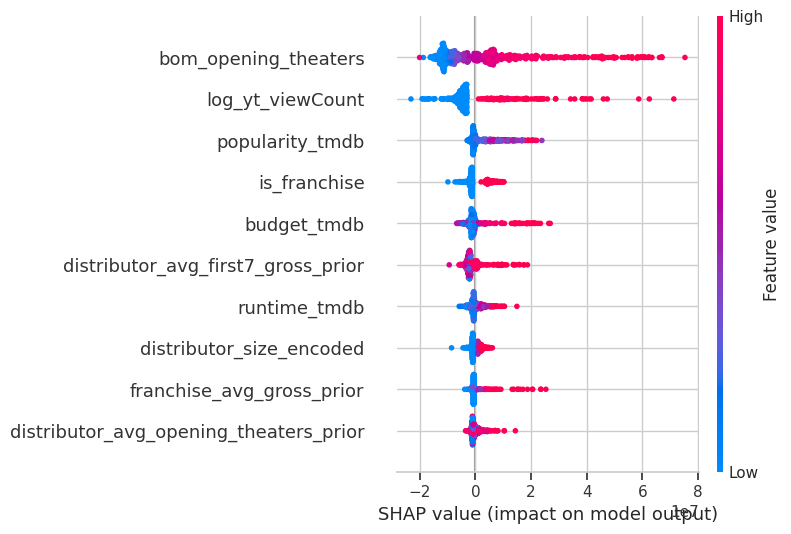

In [376]:
# Directional Impact

shap.summary_plot(
    shap_values,
    X_test,
    max_display=10
)


## *Analytical Insight*

This SHAP beeswarm plot shows not only which features are important, but also **how their values affect predictions**. Each point represents a movie, where color indicates feature value (red = high, blue = low) and position shows whether the feature increases or decreases predicted revenue.

**Higher values of opening theaters, YouTube trailer views, popularity, and budget consistently push predictions upward, confirming their strong positive relationship with first-week box office performance**. This **aligns** with **industry** intuition that wider releases and higher pre-release awareness drive early revenue.

**Franchise-related features** also show a **positive directional impact**, especially when prior franchise performance is strong. In contrast, calendar effects such as release month have a smaller and more mixed influence, suggesting they play a secondary role compared to scale and demand signals.

Overall, this plot confirms that the **model responds sensibly** to increases in real-world planning variables, reinforcing both interpretability and trustworthiness of the final model.


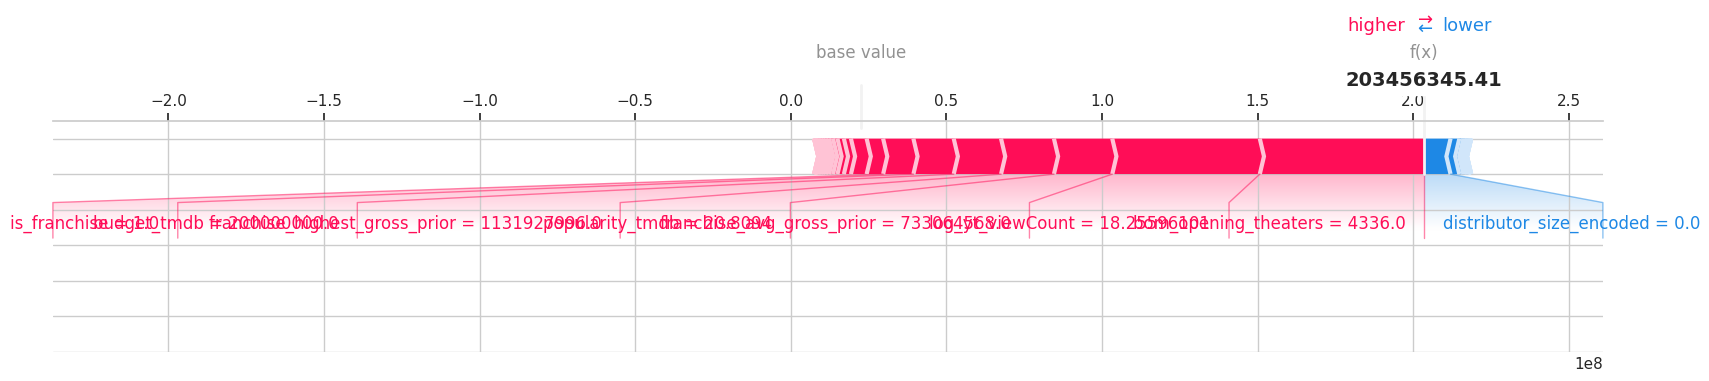

In [377]:
# Local Explanation(One Movie)

idx = np.argmax(y_test.values)  # highest revenue movie in test set

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test.iloc[idx],
    matplotlib=True
)


## *Analytical Insight*

This **SHAP force plot** explains the prediction for a single high-revenue movie in the test set. The **base value** represents the model’s **average prediction** across all movies, while the **colored contributions** show how individual features **push the prediction** higher or lower.

In this example, features such as **opening theaters, YouTube trailer views, budget, popularity, and strong franchise** history contribute positively and **push the predicted first-week revenue** far above the baseline. These signals reflect large release scale, strong pre-release awareness, and established brand strength.

A small number of features exert negative influence, slightly pulling the prediction down, but their impact is outweighed by dominant scale and demand-related factors. This aligns with industry intuition for blockbuster-level releases. Overall, this local explanation demonstrates how the model combines **multiple pre-release signals** to arrive at a high revenue prediction in a transparent and interpretable manner.


In [378]:
# Save Shap Plot

plt.savefig("shap_summary_catboost.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

## **Artifacts Saved**

To ensure reproducibility and real-world usability, all important outputs from the final model were saved as artifacts.


In [379]:
# Artifacts Directory

import os

ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)


In [380]:
# Save the final model (CatBoost Tuned)

final_model = best_cat

model_path = os.path.join(ARTIFACT_DIR, "catboost_final.cbm")
final_model.save_model(model_path)


In [381]:
# Save Feature List

import json

feature_list = list(X_train.columns)

with open(os.path.join(ARTIFACT_DIR, "feature_list.json"), "w") as f:
    json.dump(feature_list, f)


In [382]:
# Save Training Meta Data

training_metadata = {
    "model_type": "CatBoostRegressor",
    "target": "bom_first7_sum",
    "population": "Wide studio releases with disclosed budgets",
    "log_target_used": False,
    "evaluation_metric": "RMSE",
    "rmse_test": float(cat_results["RMSE_test"]),
    "mae_test": float(cat_results["MAE_test"]),
    "r2_test": float(cat_results["R2_test"]),
    "random_seed": 42
}

with open(os.path.join(ARTIFACT_DIR, "training_metadata.json"), "w") as f:
    json.dump(training_metadata, f, indent=2)


In [383]:
# Save Evaluation Table

results_df.to_csv(
    os.path.join(ARTIFACT_DIR, "model_comparison.csv"),
    index=True
)

The final CatBoost model and all supporting artifacts were saved to enable reproducible inference.  
Saved artifacts include the trained model, feature list, and training metadata to prevent feature mismatch and ensure operational deployment.


## **Inference**
After finalizing and tuning the **CatBoost model**, it was used to perform a single inference for a real-world blockbuster scenario. The objective of this step is to demonstrate how the trained model can be applied for **pre-release planning and forecasting**.

In [384]:
# Lock Final Model

final_model = best_cat


In [385]:
# Lock Features

final_features = X_train.columns.tolist()
len(final_features), final_features


(50,
 ['budget_tmdb',
  'runtime_tmdb',
  'popularity_tmdb',
  'log_yt_viewCount',
  'cast_top10_y',
  'lead_actor_demand_weighted',
  'actor_has_prior_history',
  'director_demand_weighted',
  'director_has_prior_history',
  'distributor_size_encoded',
  'distributor_avg_first7_gross_prior',
  'distributor_avg_opening_theaters_prior',
  'distributor_has_prior_history',
  'is_franchise',
  'is_sequel',
  'is_first_in_franchise',
  'movies_before_this',
  'franchise_has_prior_history',
  'franchise_avg_gross_prior',
  'franchise_highest_gross_prior',
  'is_christmas_week',
  'is_newyear_week',
  'is_thanksgiving_week',
  'is_easter_week',
  'is_long_weekend_release',
  'release_month_sin',
  'release_month_cos',
  'bom_opening_theaters',
  'has_budget_info',
  'has_opening_theaters',
  'mpaa_rating_encoded',
  'genre_Action',
  'genre_Adventure',
  'genre_Animation',
  'genre_Comedy',
  'genre_Crime',
  'genre_Documentary',
  'genre_Drama',
  'genre_Family',
  'genre_Fantasy',
  'genre_

To ensure **consistency**, the model was **locked** along with the exact feature set used during training. All input values for Avatar were constructed using **plausible pre-release estimates**, not post-release information. For **extreme features** such as budget, popularity, and YouTube view counts, values were **capped at the 99th percentile** of the training data. This **prevents unrealistic extrapolation** beyond what the model has observed during training.

In [386]:
# Caps

caps = {
    "budget_tmdb": df["budget_tmdb"].quantile(0.99),
    "popularity_tmdb": df["popularity_tmdb"].quantile(0.99),
    "lead_actor_demand_weighted": df["lead_actor_demand_weighted"].quantile(0.99),
    "director_demand_weighted": df["director_demand_weighted"].quantile(0.99),
}
caps["log_yt_viewCount"] = df["log_yt_viewCount"].quantile(0.99)

## **Avatar Fire and Ash Prediction**

In [387]:
avatar_dict = {
    # Budget & scale
    "budget_tmdb": min(400_000_000, caps["budget_tmdb"]),
    "runtime_tmdb": 195,
    "has_budget_info": 1,

    # Popularity & marketing
    "popularity_tmdb": caps["popularity_tmdb"],
    "log_yt_viewCount": caps["log_yt_viewCount"],

    # Talent
    "lead_actor_demand_weighted": caps["lead_actor_demand_weighted"],
    "actor_has_prior_history": 1,
    "director_demand_weighted": caps["director_demand_weighted"],
    "director_has_prior_history": 1,

    # Distributor
    "distributor_size_encoded": 2,
    "distributor_avg_first7_gross_prior": 85_000_000,
    "distributor_avg_opening_theaters_prior": 4200,
    "distributor_has_prior_history": 1,

    # Franchise
    "is_franchise": 1,
    "is_sequel": 1,
    "is_first_in_franchise": 0,
    "movies_before_this": 4,
    "franchise_has_prior_history": 1,
    "franchise_avg_gross_prior": 150_000_000,
    "franchise_highest_gross_prior": 180_000_000,

    # Calendar
    "is_christmas_week": 1,
    "is_newyear_week": 0,
    "is_long_weekend_release": 1,
    "release_month_sin": np.sin(12 * 2 * np.pi / 12),
    "release_month_cos": np.cos(12 * 2 * np.pi / 12),

    # Opening scale (planned)
    "bom_opening_theaters": 4200,
}


**Features** related to franchise history, distributor strength, and release timing were **populated** based on **industry knowledge** and **prior franchise performance**. **Genre** information was **encoded** using the same **multi-label binary** format as the training data to maintain full alignment.

In [388]:
# Genres

avatar_genres = {
    "genre_Action": 1,
    "genre_Adventure": 1,
    'genre_Fantasy': 1,
    'genre_Thriller': 1,
    "genre_Science Fiction": 1
}


In [389]:
# Assemble inference DataFrame

avatar_df = pd.DataFrame([avatar_dict])

# Add genre columns
for col in final_features:
    if col.startswith("genre_") and col not in avatar_df.columns:
        avatar_df[col] = 0

# Add missing non-genre columns
for col in final_features:
    if col not in avatar_df.columns:
        avatar_df[col] = 0

# Reorder columns EXACTLY
avatar_df = avatar_df[final_features]

avatar_df.shape


(1, 50)

In [390]:
# Predict First Week Revenue

avatar_pred = final_model.predict(avatar_df)[0]
avatar_pred


np.float64(197341250.8383312)

In [391]:
# Interpretation

print(f"Predicted first-week domestic gross: ${avatar_pred:,.0f}")


Predicted first-week domestic gross: $197,341,251


## *Analytical Insights*

The final input vector was reordered to exactly match the training feature sequence before inference, ensuring the prediction pipeline remained leakage-free and reproducible.

This prediction reflects a high-confidence blockbuster outcome driven primarily by wide theatrical release, strong franchise history, large-scale marketing signals, and distributor strength, all of which align with the model’s learned behavior.


## **Summary**

* Built a **pre-release box office forecasting model** to predict first-week domestic revenue using only information realistically available before release.

* Carefully **removed post-release and leaky variables**, ensuring the model reflects real industry planning and forecasting conditions.

* Engineered **domain-specific features** such as franchise history, distributor strength, opening theater scale, and marketing demand proxies.

* Evaluated **multiple models (Random Forest, XGBoost, LightGBM, CatBoost)** using a **time-based train–test split** to preserve chronological integrity.

* Applied **hyperparameter tuning** to the strongest candidates and selected Tuned CatBoost based on test RMSE, R² stability, and generalization behavior.

* Used **SHAP explainability** to confirm that predictions are driven by intuitive business factors like opening theaters, marketing reach, budget, and franchise strength.

* Performed **a blockbuster inference case (Avatar)** to demonstrate practical deployment and interpretability of the final model.

## **Limitations and Scope of the Prediction**

* **Pre-release only:** IMDb ratings, reviews, and audience sentiment were excluded to avoid data leakage.

* **Blockbuster saturation:** Extremely high-grossing films may be slightly under-predicted due to capped features and skewed revenue distribution.

* **Estimated operational inputs:** Variables like opening theaters and marketing reach are planning estimates and may change close to release.

* **Domestic focus:** The model predicts U.S. first-week revenue and does not include international box office performance.

* **Signal ceiling:** Similar R² values across models indicate that performance is limited by available pre-release information, not algorithm choice.

* **Interpretability vs causality:** SHAP explains influence, not causal impact, of individual features.